# Systematic Overlap Scan

This notebook performs a systematic scan of overlap lengths using the optimal temperatures determined for Protein 1 and Protein 2.

**Objectives:**
1.  Run simulations for a range of overlap lengths.
2.  Record Final Energies, Energy Time-series, and Final Sequences.
3.  Generate a "Dot Plot" of Final Energies vs Overlap Length.

In [11]:
# --- IMPORTS ---
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd

# Add current directory to path to import overlappingGenes
sys.path.append(os.getcwd())
import overlappingGenes as og

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')

In [ ]:
# --- CONFIGURATION ---

# Optimal Temperatures (Updates these based on your previous benchmark results)
T1_OPTIMAL = 0.818  # Placeholder: Replace with your specific optimal T for Protein 1
T2_OPTIMAL = 0.955  # Placeholder: Replace with your specific optimal T for Protein 2

# Simulation Parameters
NUM_TRIALS = 40        # Number of independent runs per overlap
ITERATIONS = 250_000   # Number of iterations per run
SAVE_INTERVAL = 0.01   # Save energy history every 1% of iterations

# Overlap Range (Systematic Scan)
# Scanning from 12 to 102 (inclusive) in steps of 3 to maintain reading frame
OVERLAP_RANGE = np.arange(12, 103, 3)
print(f"Scanning {len(OVERLAP_RANGE)} overlap lengths: {OVERLAP_RANGE}")

Scanning 31 overlap lengths: [ 12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63
  66  69  72  75  78  81  84  87  90  93  96  99 102]


In [13]:
# --- LOAD DATA ---

def load_dca_params(base_dir, pf_name):
    params_file = os.path.join(base_dir, pf_name, f"{pf_name}_params.dat")
    print(f"Loading parameters from {params_file}...")
    J, h = og.extract_params(params_file)
    return (J, h)

def load_natural_energies_stats(base_dir, pf_name):
    filename = os.path.join(base_dir, pf_name, f"{pf_name}_naturalenergies.txt")
    energies = og.load_natural_energies(filename)
    return np.mean(energies), np.std(energies)

base_dir = os.getcwd()
dca_params_1 = load_dca_params(base_dir, "PF00004")
dca_params_2 = load_dca_params(base_dir, "PF00041")

mean_e1, std_e1 = load_natural_energies_stats(base_dir, "PF00004")
mean_e2, std_e2 = load_natural_energies_stats(base_dir, "PF00041")

len_h1 = len(dca_params_1[1])
len_h2 = len(dca_params_2[1])
prot1_len = int(len_h1 / 21)
prot2_len = int(len_h2 / 21)

print(f"\nNatural targets: PF00004 [{mean_e1:.2f} +/- {std_e1:.2f}], PF00041 [{mean_e2:.2f} +/- {std_e2:.2f}]")

Loading parameters from c:\Users\orson\OneDrive\Documents\OverlappingGenes\Project\PF00004\PF00004_params.dat...
Loading parameters from c:\Users\orson\OneDrive\Documents\OverlappingGenes\Project\PF00041\PF00041_params.dat...

Natural targets: PF00004 [145.88 +/- 38.25], PF00041 [120.66 +/- 17.64]


In [14]:
# --- SIMULATION LOOP ---

results = {
    'overlap': [],
    'final_energies_1': [],
    'final_energies_2': [],
    'final_sequences': [],
    'time_series_1': {},  # Dict to store time series for representative overlaps
    'time_series_2': {}
}

print(f"Starting scan with T1={T1_OPTIMAL}, T2={T2_OPTIMAL}...")

for overlap in OVERLAP_RANGE:
    print(f"Processing Overlap {overlap}...", end="\r")
    
    energies_1 = []
    energies_2 = []
    sequences = []
    
    # Store time series for the first trial of each overlap
    first_run_ts_1 = None
    first_run_ts_2 = None
    
    for run in range(NUM_TRIALS):
        # Initialize
        initial_seq = og.initial_seq_no_stops(prot1_len, prot2_len, overlap, quiet=True)
        
        # Run Simulation with Optimal Temperature
        final_seq, accepted, hist_e1, hist_e2, final_Es = og.overlapped_sequence_generator_int(
            dca_params_1, dca_params_2, initial_seq, 
            numberofiterations=ITERATIONS, 
            whentosave=SAVE_INTERVAL, 
            quiet=True,
            T1=T1_OPTIMAL, T2=T2_OPTIMAL
        )
        
        # Collect Results
        energies_1.append(final_Es[0])
        energies_2.append(final_Es[1])
        sequences.append(final_seq)
        
        # Store Time Series for first run only (to save memory/complexity)
        if run == 0:
            first_run_ts_1 = hist_e1
            first_run_ts_2 = hist_e2
    
    # Append to main results
    results['overlap'].append(overlap)
    results['final_energies_1'].append(energies_1)
    results['final_energies_2'].append(energies_2)
    results['final_sequences'].append(sequences)
    results['time_series_1'][overlap] = first_run_ts_1
    results['time_series_2'][overlap] = first_run_ts_2

print("\nScan Complete!")

Starting scan with T1=0.818, T2=0.955...
Processing Overlap 102...
Scan Complete!


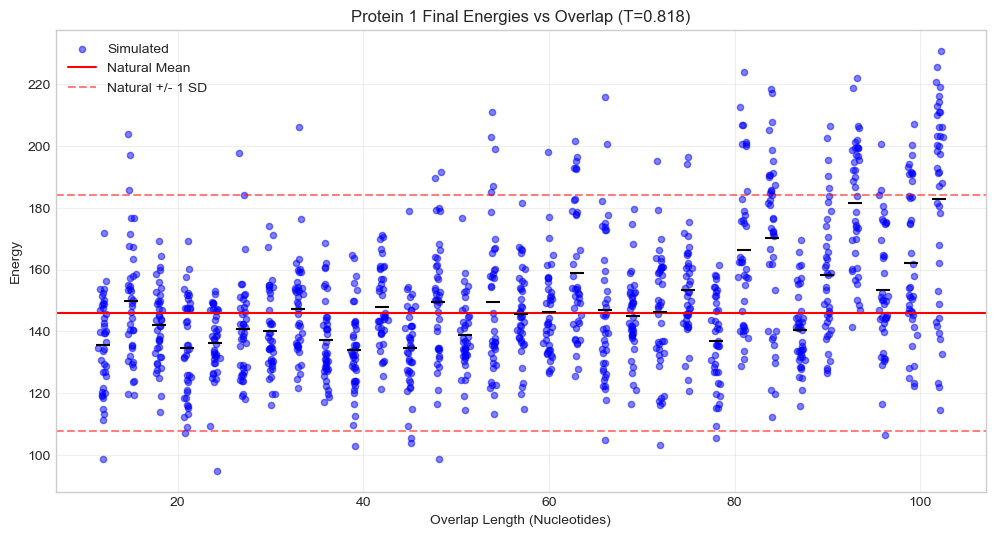

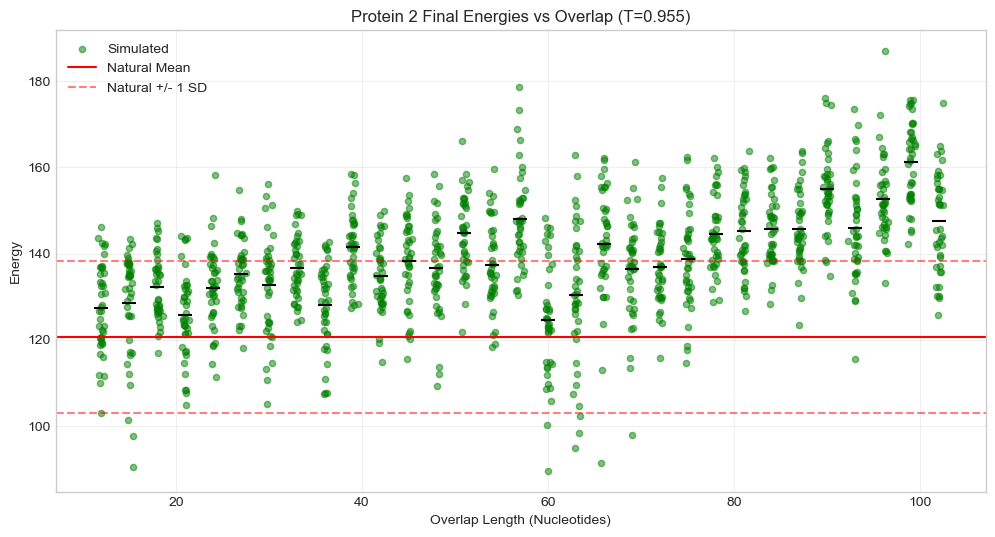

In [15]:
# --- DOT PLOT: Final Energies vs Overlap ---

def plot_dot_plot(results, mean_e, std_e, protein_idx, title, color):
    plt.figure(figsize=(12, 6))
    
    overlaps = results['overlap']
    final_energies_list = results[f'final_energies_{protein_idx}']
    
    # Plot dots for each trial
    for i, overlap in enumerate(overlaps):
        energies = final_energies_list[i]
        # Add some jitter to x for visibility if desired, or keep straight
        jitter = np.random.normal(0, 0.2, size=len(energies))
        plt.scatter(np.full_like(energies, overlap) + jitter, energies, 
                    color=color, alpha=0.5, s=20, label='Simulated' if i == 0 else "")
        
        # Optional: Plot mean marker
        plt.scatter(overlap, np.mean(energies), color='black', marker='_', s=100, zorder=10)

    # Reference Lines
    plt.axhline(mean_e, color='red', linestyle='-', label='Natural Mean')
    plt.axhline(mean_e + std_e, color='red', linestyle='--', alpha=0.5, label='Natural +/- 1 SD')
    plt.axhline(mean_e - std_e, color='red', linestyle='--', alpha=0.5)
    
    plt.xlabel('Overlap Length (Nucleotides)')
    plt.ylabel('Energy')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Plot Protein 1
plot_dot_plot(results, mean_e1, std_e1, 1, f"Protein 1 Final Energies vs Overlap (T={T1_OPTIMAL})", 'blue')

# Plot Protein 2
plot_dot_plot(results, mean_e2, std_e2, 2, f"Protein 2 Final Energies vs Overlap (T={T2_OPTIMAL})", 'green')

seems for pf00041 i chose the one overlap, 60, that is somewhat an outlier when calculating ideal temperature

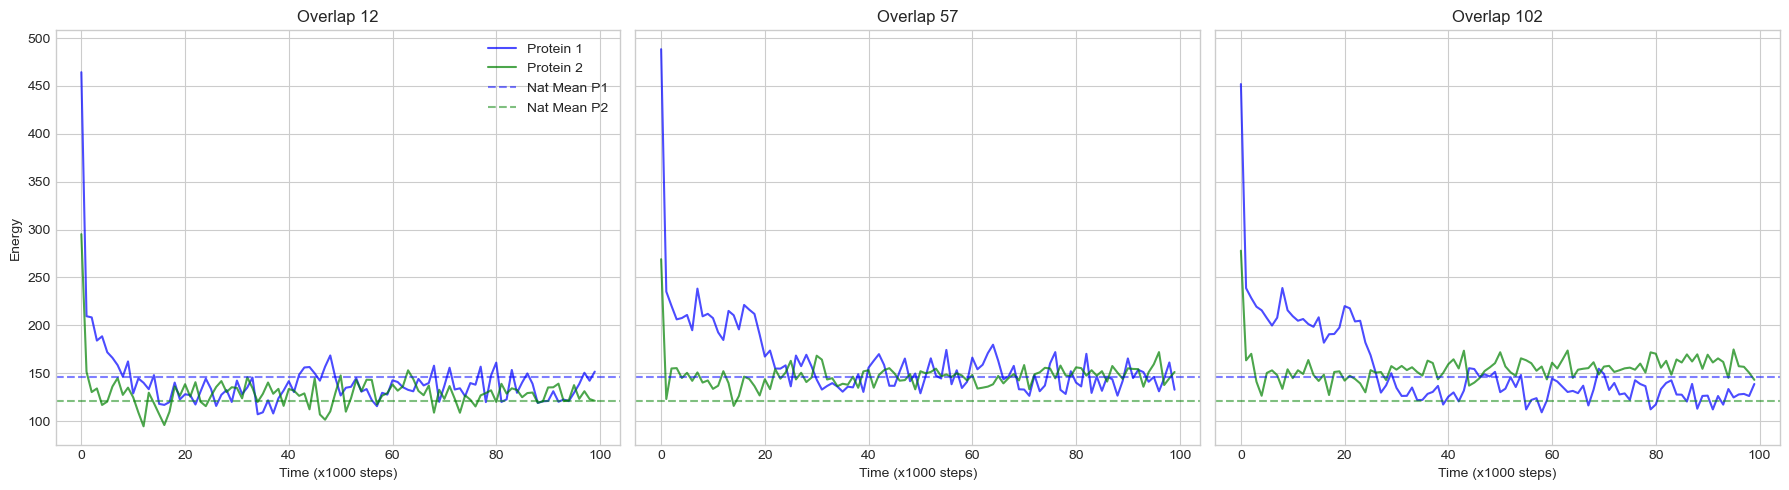

In [16]:
# --- TIME SERIES PLOTS (Representative Overlaps) ---

# Pick 3 overlaps: Start, Middle, End
sample_overlaps = [OVERLAP_RANGE[0], OVERLAP_RANGE[len(OVERLAP_RANGE)//2], OVERLAP_RANGE[-1]]

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, ov in enumerate(sample_overlaps):
    ax = axes[i]
    ts1 = results['time_series_1'][ov]
    ts2 = results['time_series_2'][ov]
    
    ax.plot(ts1, color='blue', alpha=0.7, label='Protein 1')
    ax.plot(ts2, color='green', alpha=0.7, label='Protein 2')
    
    # Reference lines
    ax.axhline(mean_e1, color='blue', linestyle='--', alpha=0.5, label='Nat Mean P1')
    ax.axhline(mean_e2, color='green', linestyle='--', alpha=0.5, label='Nat Mean P2')
    
    ax.set_title(f'Overlap {ov}')
    ax.set_xlabel('Time (x1000 steps)')
    if i == 0:
        ax.set_ylabel('Energy')
        ax.legend()

plt.tight_layout()
plt.show()